In [1]:
from bwb.transports import MySinkhornTransport, MyEMDTransport

In [2]:
import numpy as np

data = np.load(r"..\data\face.npy")
data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [3]:
%%time
from bwb.distributions import DistributionDrawBuilder


CEIL = 50
n_faces = len(data)
rng = np.random.default_rng(42)


# Builder para hacer las caritas
dist_draw_builder = DistributionDrawBuilder(
    seed=rng,
)

# Conjunto de caritas originales (distintos soportes)
faces_original = list()
for i in range(n_faces):
    arr = 255 - data[i, :].reshape(28, 28)
    dd_arr = dist_draw_builder.create_fromarray(arr)
    faces_original.append(dd_arr)

CPU times: total: 4.34 s
Wall time: 4.35 s


In [4]:
from bwb.utils import plot_list_of_draws

plot_list_of_draws(faces_original)

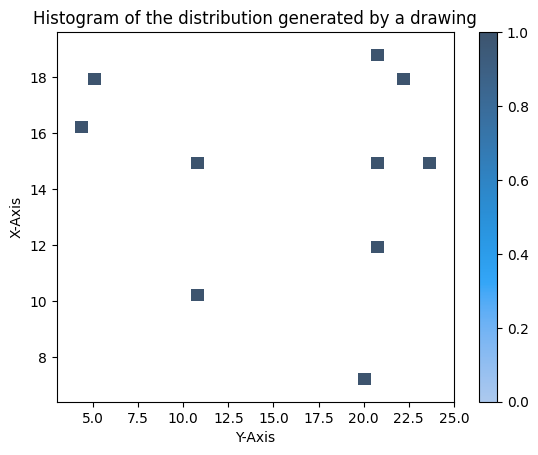

In [5]:
from matplotlib import pyplot as plt
from bwb.utils import plot_histogram_from_points
from bwb.distributions import DistributionDraw

first_face = DistributionDraw.fromarray(
    255 - data[0, :].reshape(28, 28),
    seed=42
)

x = first_face.rvs(size=10)

plot_histogram_from_points(x, histplot_kwargs=dict(bins=28))
plt.show()

# Instanciando y "quemando" el MCMC

In [6]:
%%time
from bwb.distributions import GibbsPosteriorPiN

pi_n = GibbsPosteriorPiN(data=x, models=faces_original[1:], seed=rng)

CPU times: total: 7.02 s
Wall time: 7.04 s


In [7]:
%%time
pi_n.rvs(size=1_000)
pi_n

CPU times: total: 17.8 s
Wall time: 18 s


GibbsPosteriorPiN(n_data=10, n_models=161665, n_samples=1000, last_i=132283, likelihood_sum=2.8429e-21)

In [8]:
print(f"{len(pi_n.counter.most_common()) = }")
pi_n.counter.most_common()

len(pi_n.counter.most_common()) = 290


[(51622, 39),
 (120958, 34),
 (74975, 34),
 (574, 29),
 (44641, 28),
 (161622, 27),
 (132725, 26),
 (1718, 26),
 (115337, 22),
 (132283, 20),
 (144293, 20),
 (24317, 16),
 (110719, 15),
 (105627, 12),
 (14355, 11),
 (78134, 11),
 (7900, 10),
 (17818, 10),
 (103548, 10),
 (48836, 10),
 (132946, 10),
 (55991, 9),
 (23792, 8),
 (144339, 8),
 (101495, 8),
 (79010, 8),
 (50769, 7),
 (114785, 7),
 (27681, 7),
 (121272, 7),
 (109796, 6),
 (7529, 6),
 (3247, 6),
 (41610, 6),
 (118846, 6),
 (132734, 6),
 (146831, 6),
 (100078, 6),
 (23324, 5),
 (47604, 5),
 (30824, 5),
 (54732, 5),
 (93600, 5),
 (133917, 5),
 (33126, 5),
 (69942, 4),
 (66718, 4),
 (82422, 4),
 (100468, 4),
 (43673, 4),
 (66446, 4),
 (151966, 4),
 (46685, 4),
 (66269, 4),
 (36620, 4),
 (22167, 4),
 (27833, 4),
 (102356, 4),
 (142501, 4),
 (14987, 4),
 (87434, 4),
 (38154, 4),
 (50576, 4),
 (138106, 4),
 (74383, 4),
 (66759, 4),
 (79185, 3),
 (154912, 3),
 (34656, 3),
 (785, 3),
 (66101, 3),
 (44893, 3),
 (46097, 3),
 (24259, 3),

In [9]:
plot_list_of_draws(pi_n.most_common())

# Algoritmo del descenso del gradiente estocástico

Ahora se programará el descenso del gradiente estocástico usando la posterior $\Pi_n$

In [10]:
def as_matrix(weights, places, shape):
    assert len(weights) == len(places), f"El tamaño de los pesos y de los puntos soporte no coinciden: {len(weights) = }, {len(places) = }"

    to_return = np.zeros(shape)
    for row, weight in zip(places.astype(int), weights):
        to_return[tuple(row)] += weight

    return to_return

# mat = as_matrix(mu_s, Xs, mu_0.shape)

from bwb.utils import plot_list_of_draws
from PIL import Image

def matrix_to_image_array(matrix: np.ndarray):
    matrix_: np.ndarray = np.ceil(255 - 255 * matrix / matrix.max())
    return matrix_.astype("uint8")

# im = Image.fromarray(matrix_to_image_array(mat))
# plot_list_of_draws([DistributionDraw(im)])

In [11]:
eps = 1e-3
alpha = 1. / 10
emd_transp = MyEMDTransport()
gamma = lambda k_: 1 / (k_ + 2)

# Camino de baricentros
mu = []

# Paso 1: samplear un mu_0
mu_0: DistributionDraw = pi_n.draw()
mu.append(mu_0)

# Calcular las masas y ubicaciones
Xs, mu_s = [], []
min_w, max_w = mu_0.weights.min(), mu_0.weights.max()

for x, w, n in zip(mu_0.support, mu_0.weights, np.ceil(alpha * mu_0.weights / min_w).astype(int)):
    for _ in range(n):
        Xs.append(x)
        mu_s.append(w / n)

Xs = np.array(Xs)
mu_s = np.array(mu_s)

print(f"{len(Xs) = }")

k = 0

while True:
    print(f"{k = }")
    # Paso 2: Samplear \tilde\mu_k
    t_mu_k: DistributionDraw = pi_n.draw()
    Xt, mu_t = np.array(t_mu_k.support), np.array(t_mu_k.weights)

    # Calcular transporte óptimo
    emd_transp.fit_wm(
        Xs=Xs, mu_s=mu_s,
        Xt=Xt, mu_t=mu_t,
    )

    # Calcular la distribución de mu_{k+1}
    gamma_k = gamma(k)
    transport = emd_transp.transform(Xs)
    Xs_ = (1 - gamma_k) * Xs + gamma_k * transport  # Basta con calcular las transformaciones, porque los pesos son los mismos

    # Calcular la distancia de Wasserstein
    diff = Xs - transport
    W_mu_kp1_mu_k = (gamma_k ** 2) * np.sum(mu_s * np.sqrt(diff[:, 0]**2 + diff[:, 1]**2))
    print(f"{W_mu_kp1_mu_k = }")

    # Condición de detención
    if W_mu_kp1_mu_k < eps:
        break

    Xs = Xs_
    mat = as_matrix(mu_s, Xs, mu_0.shape)
    im = Image.fromarray(matrix_to_image_array(mat))
    mu.append(DistributionDraw(im))
    k += 1


len(Xs) = 3660
k = 0
W_mu_kp1_mu_k = 0.4222825332735012
k = 1
W_mu_kp1_mu_k = 0.17549623845319265
k = 2
W_mu_kp1_mu_k = 0.06829773947782236
k = 3
W_mu_kp1_mu_k = 0.05062392608054133
k = 4
W_mu_kp1_mu_k = 0.029037767662454805
k = 5
W_mu_kp1_mu_k = 0.02240405104428037
k = 6
W_mu_kp1_mu_k = 0.012493398193595547
k = 7
W_mu_kp1_mu_k = 0.01521137034403547
k = 8
W_mu_kp1_mu_k = 0.009025565715116807
k = 9
W_mu_kp1_mu_k = 0.008491260928524626
k = 10
W_mu_kp1_mu_k = 0.008877072142352506
k = 11
W_mu_kp1_mu_k = 0.012040144201302286
k = 12
W_mu_kp1_mu_k = 0.004493122855809562
k = 13
W_mu_kp1_mu_k = 0.004214817155593812
k = 14
W_mu_kp1_mu_k = 0.004990519647730608
k = 15
W_mu_kp1_mu_k = 0.0029939691690709074
k = 16
W_mu_kp1_mu_k = 0.004380711496763226
k = 17
W_mu_kp1_mu_k = 0.0026758170038886798
k = 18
W_mu_kp1_mu_k = 0.0017717142208337109
k = 19
W_mu_kp1_mu_k = 0.0024487019659142524
k = 20
W_mu_kp1_mu_k = 0.0021663056161170926
k = 21
W_mu_kp1_mu_k = 0.0027743324865120217
k = 22
W_mu_kp1_mu_k = 0.001

Primeras iteraciones del algoritmo

In [12]:
plot_list_of_draws(mu, max_images=36)

últimas iteraciones del algoritmo

In [13]:
plot_list_of_draws(mu[-36:], max_images=36)

# Descenso del gradiente estocástico, versión con Batch

In [14]:
eps = 1e-3
alpha = 1. / 10
emd_transp = MyEMDTransport()
gamma = lambda k_: 1 / (k_ + 2)
S = lambda k_: 5

# Camino de baricentros
mu = []

# Paso 1: samplear un mu_0
mu_0: DistributionDraw = pi_n.draw()
mu.append(mu_0)

# Calcular las masas y ubicaciones
Xs, mu_s = [], []
min_w, max_w = mu_0.weights.min(), mu_0.weights.max()

for x, w, n in zip(mu_0.support, mu_0.weights, np.ceil(alpha * mu_0.weights / min_w).astype(int)):
    for _ in range(n):
        Xs.append(x)
        mu_s.append(w / n)

Xs = np.array(Xs)
mu_s = np.array(mu_s)

print(f"{len(Xs) = }")

k = 0

while True:
    print(f"{k = }")
    transports = []
    for j in range(S(k)):
        print(f"{j = }")
        # Paso 2: Samplear \tilde\mu_k
        t_mu_k: DistributionDraw = pi_n.draw()
        Xt, mu_t = np.array(t_mu_k.support), np.array(t_mu_k.weights)

        # Calcular transporte óptimo
        emd_transp.fit_wm(
            Xs=Xs, mu_s=mu_s,
            Xt=Xt, mu_t=mu_t,
        )

        transports.append(emd_transp.transform(Xs))

    # Calcular la distribución de mu_{k+1}
    gamma_k = gamma(k)
    transport = np.mean(transports, axis=0)
    Xs_ = (1 - gamma_k) * Xs + gamma_k * transport  # Basta con calcular las transformaciones, porque los pesos son los mismos

    # Calcular la distancia de Wasserstein
    diff = Xs - transport
    W_mu_kp1_mu_k = (gamma_k ** 2) * np.sum(mu_s * np.sqrt(diff[:, 0]**2 + diff[:, 1]**2))
    print(f"{W_mu_kp1_mu_k = }")

    # Condición de detención
    if W_mu_kp1_mu_k < eps:
        break

    Xs = Xs_
    mat = as_matrix(mu_s, Xs, mu_0.shape)
    im = Image.fromarray(matrix_to_image_array(mat))
    mu.append(DistributionDraw(im))
    k += 1


len(Xs) = 3525
k = 0
j = 0
j = 1
j = 2
j = 3
j = 4
W_mu_kp1_mu_k = 0.1614153714927278
k = 1
j = 0
j = 1
j = 2
j = 3
j = 4
W_mu_kp1_mu_k = 0.10780827473580722
k = 2
j = 0
j = 1
j = 2
j = 3
j = 4
W_mu_kp1_mu_k = 0.05218504762215935
k = 3
j = 0
j = 1
j = 2
j = 3
j = 4
W_mu_kp1_mu_k = 0.02810466733448703
k = 4
j = 0
j = 1
j = 2
j = 3
j = 4
W_mu_kp1_mu_k = 0.030126498043881077
k = 5
j = 0
j = 1
j = 2
j = 3
j = 4
W_mu_kp1_mu_k = 0.010151050018910812
k = 6
j = 0
j = 1
j = 2
j = 3
j = 4
W_mu_kp1_mu_k = 0.010149989560368937
k = 7
j = 0
j = 1
j = 2
j = 3
j = 4
W_mu_kp1_mu_k = 0.013172121131173886
k = 8
j = 0
j = 1
j = 2
j = 3
j = 4
W_mu_kp1_mu_k = 0.005597499678562979
k = 9
j = 0
j = 1
j = 2
j = 3
j = 4
W_mu_kp1_mu_k = 0.004240438300729402
k = 10
j = 0
j = 1
j = 2
j = 3
j = 4
W_mu_kp1_mu_k = 0.0030290282585207196
k = 11
j = 0
j = 1
j = 2
j = 3
j = 4
W_mu_kp1_mu_k = 0.0033862924677062404
k = 12
j = 0
j = 1
j = 2
j = 3
j = 4
W_mu_kp1_mu_k = 0.003675242833095405
k = 13
j = 0
j = 1
j = 2
j = 3
j = 4

In [15]:
plot_list_of_draws(mu, max_images=36)

In [16]:
plot_list_of_draws(mu[-33:], max_images=36)